In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [64, 128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'

In [2]:
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

In [4]:

# class ReturnBestEarlyStopping(EarlyStopping):
#     def __init__(self, **kwargs):
#         super(ReturnBestEarlyStopping, self).__init__(**kwargs)

#     def on_train_end(self, logs=None):
#         if self.stopped_epoch > 0:
#             if self.verbose > 0:
#                 print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
#         elif self.restore_best_weights:
#             if self.verbose > 0:
#                 print('Restoring model weights from the end of the best epoch.')
#             self.model.set_weights(self.best_weights
                                   
# https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb
# Metrics2 modified from https://stackoverflow.com/a/61856587/3023033
class Metrics(Callback):
    def __init__(self, val_data):#, batch_size = 64):
        super().__init__()
        self.validation_data = val_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal = self.validation_data
        val_pred = np.argmax(np.asarray(self.model.predict(xVal)), axis=1)
        val_true = np.argmax(yVal, axis=1)        
        _val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_precision = precision_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_recall = recall_score(val_true, val_pred, average='weighted', zero_division = 0)

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        logs["val_f1"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return

In [55]:
## TEST
# imd = np.load('../../data/tidy/preprocessed_images/size64_exp5_Pr_Po_Im.npy',allow_pickle = True)
# trimg,vaimg,trlab,valab =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in imd]), 
#                  np.array([x[1] for x in imd]), stratify= np.array([x[1] for x in imd]), test_size=.2, random_state = 1  )
# print(trlab.sum(axis=0))
# print(valab.sum(axis=0))

In [3]:
imd128 = np.load('../../data/tidy/preprocessed_images/size128_exp5_Pr_Po_Im.npy',allow_pickle = True)
imd64 = np.load('../../data/tidy/preprocessed_images/size64_exp5_Pr_Po_Im.npy',allow_pickle = True)

In [16]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
X = np.array([np.expand_dims(x[0],axis=2) for x in image_sets[64]["Pr_Po_Im"]])
y = np.array([x[1] for x in image_sets[64]["Pr_Po_Im"]])
#X = np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]])
#y = np.array([x[1] for x in image_sets[image_size][scenario]])
skf.get_n_splits(X, y)
for i, (train_index, test_index) in enumerate(skf.split(X, y.argmax(1))):
    print(len(train_index), test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(y[test_index])

2020 [   0    3    4    6    9   17   27   29   30   37   44   47   55   64
   68   74   75   78   83   88   89   95   98  101  102  111  116  118
  120  121  124  127  150  161  166  176  177  182  183  185  186  192
  205  210  215  224  227  231  239  241  242  251  266  281  283  285
  288  296  301  302  307  312  313  319  324  328  333  336  339  362
  382  386  397  398  401  408  409  413  421  424  426  435  446  452
  465  470  492  501  503  507  514  521  526  528  539  544  558  559
  562  578  579  581  589  604  605  609  611  616  620  625  626  632
  633  641  643  645  648  652  656  658  668  670  671  675  678  679
  688  690  695  709  719  720  721  722  733  738  747  750  751  752
  754  755  759  760  763  766  771  774  775  785  790  797  804  809
  812  823  826  829  832  841  854  861  867  872  873  880  883  885
  892  896  897  900  906  915  917  920  921  926  930  932  938  948
  950  954  967  968  973  977  987  988  990  997  998 1009 1010 1026
 

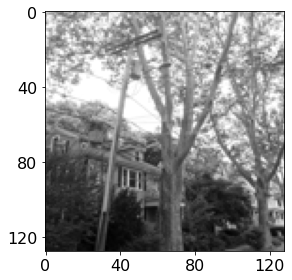

In [82]:
## Generates the subfigures in Figure 2 in the paper.
imd128 = np.load('../../data/tidy/preprocessed_images/size128_exp5_Pr_Po_Im.npy',allow_pickle = True)
example_image_list = [1790, 1792, 
                      2235, 2237, 
                      950, 951, 
                      1180, 1181, 
                      2110, 2111,
                      1301, 1302
                     ]
example_image_filenames = ['probable-example-1.png', 'probable-example-1-flipped.png',
                          'probable-example-2.png', 'probable-example-2-flipped.png',
                          'possible-example-1.png', 'possible-example-1-flipped.png',
                          'possible-example-2.png', 'possible-example-2-flipped.png',   
                          'improbable-example-1.png', 'improbable-example-1-flipped.png',
                          'improbable-example-2.png', 'improbable-example-2-flipped.png',                            
                          ]
for i,n in enumerate(example_image_list):
    plt.imshow(imd128[n][0], cmap = 'gist_gray')
    plt.tight_layout()
    plt.yticks([0,40,80,120],fontsize=16)
    plt.xticks([0,40,80,120],fontsize=16)
    plt.savefig('../../figures/processed-' + example_image_filenames[i], dpi=180,bbox_inches='tight')

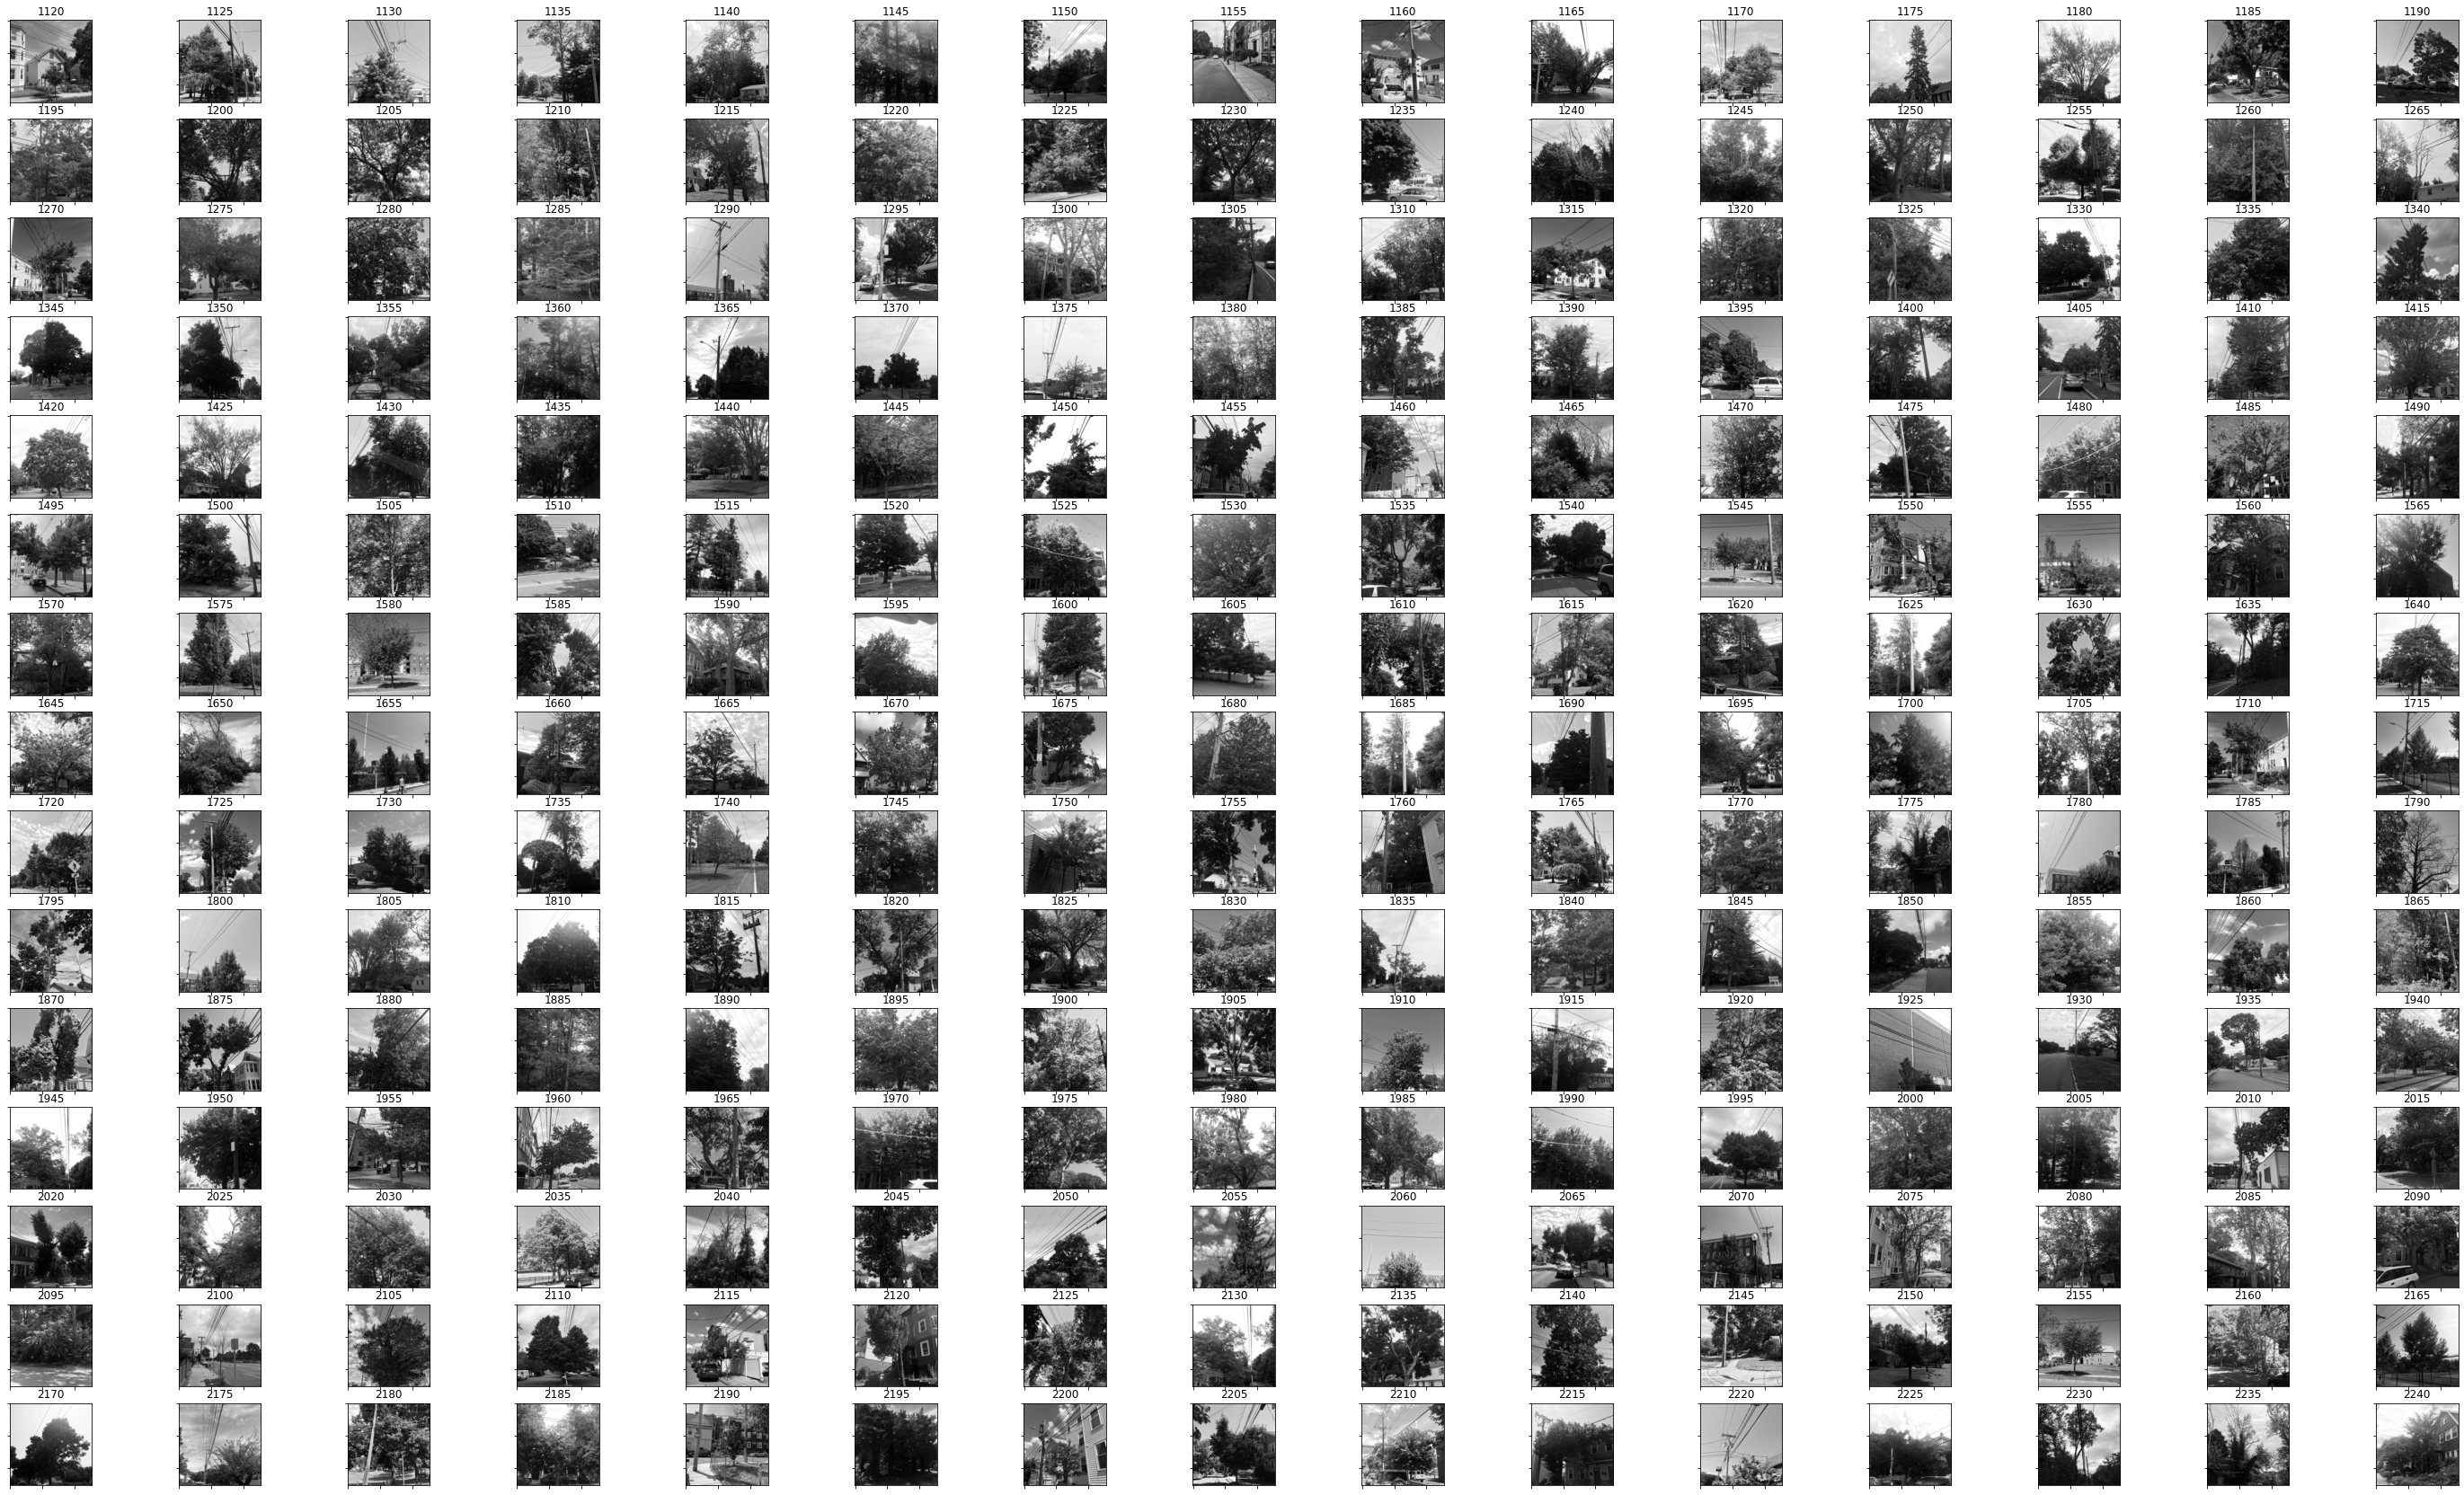

In [49]:
#To scan through all the images briefly!
rows= 15
cols = 15
f, ax = plt.subplots(rows,cols, figsize=(50,30))
k = 1120 #1120 #2240
for i in np.arange(rows):
    for j in np.arange(cols):
        ax[i][j].set_title(str(k))
        ax[i][j].imshow(imd128[k][0], cmap = 'gist_gray')
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])
        k += 5
#plt.savefig('....', dpi=180)

In [36]:
def trainModelWithDetailedMetrics(image_size, scenario, num_epochs = 10, trial_seed = 1): 
    
    # IMAGES (former approach)
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
#     training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]]), 
#                                                                                                np.array([x[1] for x in image_sets[image_size][scenario]]), 
#                                                                                                stratify= np.array([x[1] for x in image_sets[image_size][scenario]]), 
#                                                                                                test_size = .2, random_state = 1)

    print("Number of class training images:", training_labels.sum(axis=0), "total: ", training_labels.sum())
    print("Number of class validation images:", validation_labels.sum(axis=0), "total: ", validation_labels.sum())
    
    # CALLBACKS
    model_metrics = Metrics(val_data=(validation_images, validation_labels))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5) 
    
    # INIT MODEL AND PARAMS, FIT
    K.clear_session()
    ## shape of images
    input_shape = (image_size, image_size, NUM_CHANNELS)
    ## learning rate
    opt_learning_rate = getOptCNNHyperparams(image_size, scenario)['learning_rate']
    opt = tf.keras.optimizers.Adam(learning_rate = opt_learning_rate)
    ## get model
    model = constructBaseCNN(image_size, scenario, num_channels = NUM_CHANNELS)
    reset_weights(model) # re-initialize model weights
    ## compile and fit
    model.compile(loss='categorical_crossentropy',  optimizer = opt, metrics =  ['accuracy']) 
    hist = model.fit(training_images, training_labels, batch_size = 32, epochs = num_epochs, verbose=1, 
                     validation_data=(validation_images, validation_labels),
                     callbacks = [model_metrics, early_stopping])     
    
    # SAVE MODEL, SUMMARY AND PERFORMANCE
    model_name = "opt-cnn-" + scenario + "-" +str(image_size) + "-px"
    model_folder = "model"
    if not os.path.exists(SAVED_MODEL_DIR):  
        os.makedirs(SAVED_MODEL_DIR)
#     model.save(os.path.join(SAVED_MODEL_DIR, model_name, model_folder))
#     ## Save model summary
#     print(os.path.join(SAVED_MODEL_DIR, model_name, "summary.txt"))
#     with open(os.path.join(SAVED_MODEL_DIR, model_name, "summary.txt"), 'w') as f:
#         model.summary(print_fn=lambda x: f.write(x + '\n'))
#     with open(os.path.join(SAVED_MODEL_DIR, model_name, "history.txt"), 'w') as f:
#         f.write(json.dumps(hist.history))    
   
    # ANALYZE PERFORMANCE AND SAVE OUTPUTS
#     if not os.path.exists(MODEL_PERFORMANCE_DIR):  
#         os.makedirs(MODEL_PERFORMANCE_DIR)
    ## Params
    y_pred = np.argmax(model.predict(validation_images), axis=-1) 
    ## Classification report
    report = classification_report(np.argmax(validation_labels, axis=-1), y_pred, zero_division=0,
                                   labels = np.arange(len(class_labels)), target_names=class_labels, output_dict=True)
    print("Classification report for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    report = pd.DataFrame(report).transpose().round(2)
    if not os.path.exists('../../results/classification-reports/'):  
        os.makedirs('../../results/classification-reports/')
    #report_filename = "classification-report" #os.path.join(MODEL_PERFORMANCE_DIR, )
    #report.to_csv("../../results/classification-reports/opt-classification-report-" + scenario + "-" + str(image_size) + "-px.csv")
    print(report)
    
    ## Confusion matrix
    con_mat = tf.math.confusion_matrix(labels=np.argmax(validation_labels, axis=-1), predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index = class_labels, columns = class_labels)
    #print("Confusion matrix for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    #print(con_mat_df)
    ## Confusion matrix heatmap
    figure = plt.figure(figsize=(4, 4))
    ax = sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g', cbar = False, annot_kws={"size": 16})
    figure.tight_layout()
    plt.ylabel('True',fontsize=16)
    ax.set_yticklabels(class_labels,va='center',fontsize=14)
    ax.set_xticklabels(class_labels, ha='center',fontsize=14)
    plt.xlabel('Predicted',fontsize=16)
    plt.show()
    con_mat_heatmap_file = "../../figures/test-opt-confusion-matrix-" + scenario + "-" + str(image_size) + "-px.png"
    figure.savefig(con_mat_heatmap_file, dpi=180, bbox_inches='tight')
    return(model, hist) #performance_dict)



In [6]:
def getScenarioModelPerformance(res = 64, num_epochs = 15):
    df = pd.DataFrame()
    for s in SCENARIO_LIST:
        m, h = trainModelWithDetailedMetrics(res, s, num_epochs)
        visualizeCNN(m, s, res, images_per_class = 4, seed_num = 1)       
        perf = pd.DataFrame.from_dict(h.history)
        perf[['Scenario']] = s
        perf['epoch'] = perf.index + 1
        df = df.append(perf, ignore_index=True)
    df_filename = "../../results/opt-cnn-performance-metrics-summary-" + str(res) + "px.csv"
    df.to_csv(df_filename)
    return df

In [13]:
dfm

,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0.542666,0.735294,0.615232,0.757647,0.653179,0.757647,0.574029,Pr_Im,1
1,0.485928,0.771765,0.585822,0.757647,0.653179,0.757647,0.574029,Pr_Im,2
2,0.637079,0.625743,0.662973,0.637624,0.496529,0.637624,0.406564,PrPo_Im,1
3,0.597739,0.673762,0.659182,0.663366,0.566131,0.663366,0.702949,PrPo_Im,2
4,0.619283,0.672772,0.545321,0.796040,0.705640,0.796040,0.633679,Pr_PoIm,1
5,0.486247,0.800000,0.498400,0.796040,0.705640,0.796040,0.633679,Pr_PoIm,2
6,1.016905,0.511386,0.970385,0.637624,0.496529,0.637624,0.406564,Pr_Po_Im,1
7,0.876719,0.638119,0.898135,0.637624,0.496529,0.637624,0.406564,Pr_Po_Im,2
